In [58]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score
import math
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC
from operator import truediv

In [3]:
def learnLanguage(file, doc2vec):
    
    
    data = pd.read_csv(file)
    X = pd.read_csv(doc2vec, index_col = False, delimiter = ',', header = None)
    y = data["Language"]
    
    y = pd.Series(y)
    # Assuming you have a feature matrix `X` and a target variable `y`
    # X should contain other features like doc2vec and word frequency counts
    # y should contain the language labels (with missing values)

    # Split the dataset into instances with and without missing language values
    X_with_language = X[~y.isnull()]
    y_with_language = y[~y.isnull()]
    X_missing_language = X[y.isnull()]

    # Split the dataset with language into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_with_language, y_with_language, test_size=0.2, random_state=42)

    # Train a Random Forest classifier on the instances with language
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Predict the missing language values using the trained model
    imputed_language = rf.predict(X_missing_language)

    # Merge the imputed language values with the original dataset
    y[y.isnull()] = imputed_language

    # Now you can proceed with your machine learning algorithm using the complete dataset
    return y

In [4]:
# Function that converts a categorical feature into nominal, while maintaing categorical properties
def numericise_categorical_data(df, feature):
    df[feature] = df[feature].astype(str)
    df[feature] = df[feature].astype('category')
    df_encoded = pd.get_dummies(df, columns=[feature])
    
    encoder = LabelEncoder()
    df[feature] = encoder.fit_transform(df[feature])

In [5]:
# Load the dataset
train_df = pd.read_csv('project_data_files/book_rating_train.csv')
test_df = pd.read_csv('project_data_files/book_rating_test.csv')

# Add the predicted languages to each entry
lang = learnLanguage('project_data_files/book_rating_train.csv', "project_data_files/book_text_features_doc2vec/train_desc_doc2vec100.csv")
train_df['Language'] = lang

In [6]:
def add_letter_to_cols(df, letter):
    for column in df.columns:
        new_name = letter + str(column)
        df.rename(columns={column: new_name}, inplace=True)

In [7]:
train_df = train_df.drop('Name', axis=1)
train_df = train_df.drop('Description', axis=1)
train_df = train_df.drop('Authors', axis=1)


# Remove the title, description and replace with doc2vec
book_name_features = pd.read_csv(r"project_data_files/book_text_features_doc2vec/train_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
add_letter_to_cols(book_name_features, "n")

book_desc_features = pd.read_csv(r"project_data_files/book_text_features_doc2vec/train_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
add_letter_to_cols(book_desc_features, "d")

book_auth_features = pd.read_csv(r"project_data_files/book_text_features_doc2vec/train_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
add_letter_to_cols(book_auth_features, "a")

combined_df = pd.concat([train_df, book_name_features, book_desc_features, book_auth_features], axis=1)

In [49]:
# Perform label encoding for publishers, language
#combined_df['Publisher'] = label_encoder.fit_transform(combined_df['Publisher'])
#combined_df['Language'] = label_encoder.fit_transform(combined_df['Language'])
numericise_categorical_data(combined_df, 'Publisher')
numericise_categorical_data(combined_df, 'Language')

#combined_df = pd.concat([book_name_features, book_desc_features, train_df['rating_label']], axis=1)
# Separate the feature columns (X) and the target column (y)
X = combined_df.copy()
X = X.drop('rating_label', axis=1)
y = combined_df['rating_label']

In [50]:
y

0        4.0
1        4.0
2        4.0
3        4.0
4        3.0
        ... 
23058    4.0
23059    4.0
23060    4.0
23061    4.0
23062    4.0
Name: rating_label, Length: 23063, dtype: float64

In [10]:
# MODEL 1: Collect categorical data, then use Categorical Naive Bayes

# Assuming 'X' is your feature matrix and 'y' is your target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select categorical and continuous features
categorical_features = ['Publisher', 'Language']  # Add your categorical feature column names here
continuous_features = ['con_feature1', 'con_feature2']  # Add your continuous feature column names here

# Create and train the Categorical Naive Bayes classifier
nb_classifier = CategoricalNB()
nb_classifier.fit(X_train[categorical_features], y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test[categorical_features])

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

combined = pd.concat([pd.Series(y_pred), y_test.reset_index()], axis=1)
combined

Accuracy: 0.7045306741816605


,0,index,rating_label
0,4.0,247,4.0
1,4.0,12038,3.0
2,4.0,1580,4.0
3,3.0,3128,4.0
4,4.0,20531,4.0
...,...,...,...
4608,4.0,12586,3.0
4609,4.0,7683,4.0
4610,4.0,12912,4.0
4611,4.0,9134,4.0


In [16]:
cross_val_scores = cross_val_score(nb_classifier, X[categorical_features], y, cv=5)
cross_val_scores.mean()

0.7020768543365793

In [81]:
continuous_features = [col for col in X.columns if col != 'Language' and col != 'Publisher' and col != 'rating_label']

categorical_features = ['Language', 'Publisher']

# Discretize the continuous features using equal-weight binning
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
X_continuous = X[continuous_features]
X_continuous_discretized = discretizer.fit_transform(X_continuous)


# Replace the original continuous features with the discretized values
X_discretized = X.copy()
X_discretized[continuous_features] = X_continuous_discretized


# Concatenate the categorical and discretized continuous features
X_combined = pd.concat([X[categorical_features], X_discretized[continuous_features]], axis=1)
X_combined = X_combined.drop(['Language'], axis=1)

nb_classifier = CategoricalNB()

# Perform 5-fold cross-validation and compute accuracy scores
cross_val_scores = cross_val_score(nb_classifier, X_combined, y, cv=20)

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Average Accuracy:", get_mean(cross_val_scores))

C:\Users\leoro\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 105, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 83, in predict
    jll = self._joint_log_likelihoo

Cross-Validation Scores: [0.64558059 0.67417678 0.6507799  0.66782307 0.69470945 0.64700781
 0.66435386 0.63920208 0.65307892 0.6773634  0.64093669 0.65394623
 0.65654814        nan        nan 0.63746748 0.65307892 0.64700781
 0.63920208 0.65481353]


NameError: name 'get_mean' is not defined

In [51]:
X_combined_copy = X_combined.copy()

print(X_combined_copy.shape, y.shape)

selector = SelectKBest(score_func=mutual_info_classif, k='all')
selected_features = selector.fit_transform(X_combined_copy, y)
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [X_combined_copy.columns[idx] for idx in selected_feature_indices]
selected_feature_scores = selector.scores_[selected_feature_indices]

# Sort features by score in descending order
sorted_features = sorted(zip(selected_feature_names, selected_feature_scores),
                         key=lambda x: x[1], reverse=True)

# Print the selected feature names and their mutual information scores in order
#print("Selected Features and Mutual Information Scores (in descending order):")
#for feature, score in sorted_features:
#    print(f"{feature}: {score}")

(23063, 224) (23063,)


In [59]:
def confusion_matrix_plot(y_pred, ys):
    
    labels = ys.unique()
    print(labels)
    
    cm = confusion_matrix(ys, y_pred, labels = labels)
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
    
    evalMetrics = classification_report(ys, y_pred, digits=3)
    print(evalMetrics)
    
    return cm

In [91]:
# MODEL 3: Select top n discretised features for CategoricalNB model

top_n_df= []
for feature, score in sorted_features[:5]:
    top_n_df.append(feature)


# Create and train the Categorical Naive Bayes classifier
nb_classifier = CategoricalNB()
nb_classifier.fit(X_train_combined[top_n_df], y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test_combined[top_n_df])

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy at n=", 20, ":", accuracy)

combined = pd.concat([pd.Series(y_pred), y_test.reset_index()], axis=1)

Accuracy at n= 20 : 0.7112508129200087


[4. 3. 5.]


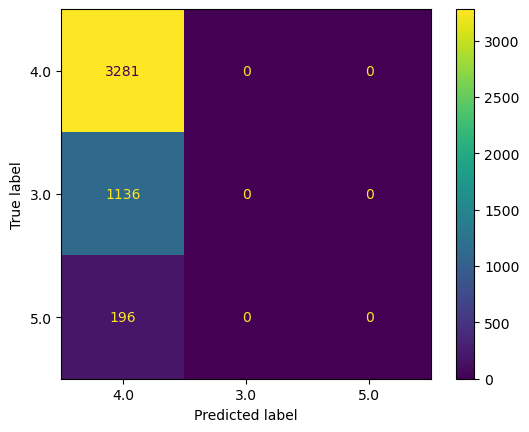

              precision    recall  f1-score   support

         3.0      0.000     0.000     0.000      1136
         4.0      0.711     1.000     0.831      3281
         5.0      0.000     0.000     0.000       196

    accuracy                          0.711      4613
   macro avg      0.237     0.333     0.277      4613
weighted avg      0.506     0.711     0.591      4613



C:\Users\leoro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\leoro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\leoro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[3281,    0,    0],
       [1136,    0,    0],
       [ 196,    0,    0]], dtype=int64)

In [92]:
confusion_matrix_plot(y_pred, y_test.reset_index()['rating_label'])

In [31]:
X_combined = pd.concat([X_discretized[categorical_features], X_discretized[continuous_features]], axis=1)
X_combined = X_combined.drop(['Publisher', 'Language'], axis=1)
X_combined

,PublishYear,PublishMonth,PublishDay,pagesNumber,n0,n1,n2,n3,n4,n5,...,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19
0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0
2,2.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0
3,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0
4,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,1.0,0.0
23059,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0
23060,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0
23061,2.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,...,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0


C:\Users\leoro\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 105, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 83, in predict
    jll = self._joint_log_likelihoo

max accuracy at 20


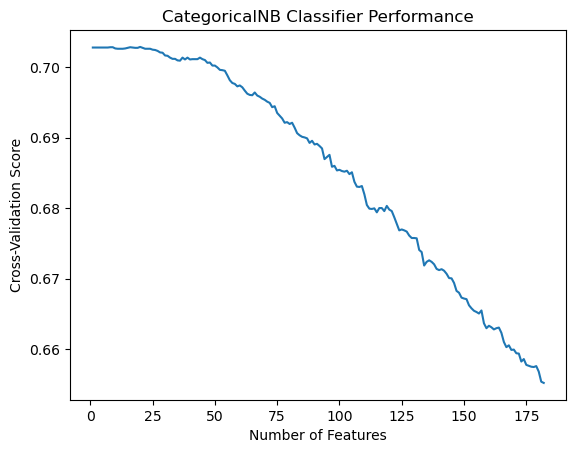

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import cross_val_score

# Define a range of feature counts
feature_counts = np.arange(1, X_combined.shape[1] + 1)



# Initialize lists to store cross-validation scores and feature counts
cv_scores = []
feature_counts_values = []

# Iterate over the feature counts
for feature_count in feature_counts:
    # Select the top features in descending order of importance/correlation
    
    top_n_df = []
    for feature, score in sorted_features[:feature_count]:
        top_n_df.append(feature)
        
    clf = CategoricalNB()
    scores = cross_val_score(clf, X_combined[top_n_df], y, cv=5)
    mean_score = np.mean(scores)

    cv_scores.append(mean_score)
    feature_counts_values.append(feature_count)

max_index = cv_scores.index(max(cv_scores))
print("max accuracy at", feature_counts_values[max_index])
# Plot the relationship between feature count and cross-validation scores
plt.plot(feature_counts_values, cv_scores)
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Score')
plt.title('CategoricalNB Classifier Performance')
plt.show()


In [204]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Assuming 'X' is your feature matrix and 'y' is your target variable
# Calculate the mutual information scores
scores = mutual_info_classif(X, y)

# Create a dictionary to store the feature names and their scores
feature_scores = dict(zip(X.columns, scores))

# Sort the feature scores in descending order
sorted_feature_scores = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature scores
#for feature, score in sorted_feature_scores:
#    print(f"Feature: {feature}, Score: {score}")


In [36]:
best_i = 0
best_acc_val = 0

for i in range(1,50):
    top_n_df = []
    for feature, score in sorted_features[:i]:
        top_n_df.append(feature)


    # Create and train the Categorical Naive Bayes classifier
    nb_classifier = CategoricalNB()
    cross_val_scores = cross_val_score(nb_classifier, X_combined[top_n_df], y, cv=20)

    # Print the cross-validation scores
    print("Cross-Validation Scores:", cross_val_scores)
    print("Average Accuracy:", get_mean(cross_val_scores))

    # Predict on the test set
    y_pred = nb_classifier.predict(X_test_combined[top_n_df])

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuracy at n=", i, ":", accuracy)

    combined = pd.concat([pd.Series(y_pred), y_test.reset_index()], axis=1)

    #print("Predicted values:")
    #print(pd.Series(y_pred).value_counts())
    #print("Actual values:")
    #print(pd.Series(y_test).value_counts())
    
    if accuracy > best_acc_val:
        best_acc_val = accuracy
        best_i = i
        
print(best_i, best_acc_val)

KeyError: "None of [Index(['Publisher'], dtype='object')] are in the [columns]"

In [163]:
pd.concat([X,y],axis=1)

,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,n0,n1,n2,n3,...,a11,a12,a13,a14,a15,a16,a17,a18,a19,rating_label
0,2005,6,1,2962,1,48,0.052262,-0.263308,0.026872,0.128574,...,0.343979,0.018261,0.115687,-0.111172,0.068306,0.158065,0.053510,-0.136804,-0.084448,4.0
1,1991,10,1,123,1,364,-0.129112,0.021312,0.159166,-0.072448,...,0.065201,0.349188,0.020555,0.281087,0.231422,0.129853,-0.213233,-0.081253,-0.204687,4.0
2,2005,3,31,4039,1,32,-0.170058,0.052351,-0.013406,0.099001,...,-0.004355,0.173353,0.087015,0.106534,0.040950,0.209152,-0.215313,-0.177547,-0.178094,4.0
3,2004,9,1,3672,1,293,0.250849,0.021555,0.091047,-0.041589,...,-0.069995,0.206028,0.089625,0.157605,0.131767,0.244849,-0.321698,-0.198365,-0.208098,4.0
4,2005,7,7,2025,1,352,-0.041681,0.038051,-0.051164,-0.076813,...,0.049880,0.003623,0.062291,-0.030742,0.130882,0.295086,-0.061550,-0.244197,-0.272161,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,1997,8,1,3915,1,120,0.007497,0.000220,0.019723,-0.003321,...,-0.003458,0.148963,0.063023,0.207720,0.070757,0.372283,-0.202811,-0.110761,-0.332954,4.0
23059,2005,6,1,673,1,32,-0.024484,0.000467,-0.015977,0.086630,...,-0.076491,0.343184,-0.041826,0.242226,0.140699,0.104105,-0.140699,-0.004226,-0.291587,4.0
23060,1989,2,15,2470,1,132,-0.099309,-0.046230,-0.033294,0.242591,...,-0.077176,0.297625,0.172478,0.149067,-0.003060,0.270723,-0.324030,-0.264965,-0.269051,4.0
23061,1998,4,21,1725,1,136,-0.038388,0.065679,-0.159324,-0.048682,...,-0.052155,0.195081,0.126226,0.097224,0.052020,0.191786,-0.234276,-0.214879,-0.224103,4.0


In [192]:
continuous_features = [col for col in X.columns if col != 'Language' and col != 'Publisher' and col != 'rating_label']

categorical_features = ['Language', 'Publisher']

# Discretize the continuous features using equal-weight binning
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
X_continuous = X[continuous_features]
X_continuous_discretized = discretizer.fit_transform(X_continuous)

# Replace the original continuous features with the discretized values
X_discretized = X.copy()
X_discretized[continuous_features] = X_continuous_discretized

# Concatenate the categorical and discretized continuous features
X_combined = pd.concat([X_discretized[categorical_features], X_discretized[continuous_features]], axis=1)
X_combined = X_combined.drop(['Publisher', 'Language'], axis=1)

# Assuming 'X' is your feature matrix and 'y' is your target variable
print(X_combined)
# Create the Categorical Naive Bayes classifier
nb_classifier = CategoricalNB()

# Perform 5-fold cross-validation and compute accuracy scores
cross_val_scores = cross_val_score(nb_classifier, X_combined, y, cv=20)

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Average Accuracy:", get_mean(cross_val_scores))


       PublishYear  PublishMonth  PublishDay  pagesNumber   n0   n1   n2   n3  \
0              2.0           1.0         0.0          0.0  1.0  0.0  1.0  1.0   
1              2.0           2.0         0.0          0.0  1.0  1.0  1.0  1.0   
2              2.0           0.0         2.0          0.0  1.0  1.0  1.0  1.0   
3              2.0           2.0         0.0          0.0  1.0  1.0  1.0  1.0   
4              2.0           1.0         0.0          0.0  1.0  1.0  1.0  1.0   
...            ...           ...         ...          ...  ...  ...  ...  ...   
23058          2.0           1.0         0.0          0.0  1.0  1.0  1.0  1.0   
23059          2.0           1.0         0.0          0.0  1.0  1.0  1.0  1.0   
23060          2.0           0.0         1.0          0.0  1.0  1.0  1.0  1.0   
23061          2.0           0.0         2.0          0.0  1.0  1.0  1.0  1.0   
23062          2.0           1.0         0.0          0.0  1.0  1.0  1.0  1.0   

        n4   n5  ...  a10  

C:\Users\leoro\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 105, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\base.py", line 651, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\leoro\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 83, in predict
    jll = self._joint_log_likelihoo

Cross-Validation Scores: [0.63258232 0.65164645 0.64818024 0.64960971 0.66608846 0.63486557
 0.65654814 0.64093669 0.64180399 0.66869037 0.63746748 0.64787511
 0.63746748 0.6444059         nan 0.64093669 0.65221162 0.63660017
 0.63313096 0.66522116]
Average Accuracy: 0.6466457110050609


In [161]:
print(X_combined.loc[4247], y.loc[4247])
print(X_combined.loc[4246], y.loc[4246])

Language           1.0
Publisher       1712.0
PublishYear        2.0
PublishMonth       2.0
PublishDay         0.0
                 ...  
a15                1.0
a16                1.0
a17                0.0
a18                1.0
a19                1.0
Name: 4247, Length: 226, dtype: float64 4.0
Language           1.0
Publisher       1810.0
PublishYear        2.0
PublishMonth       0.0
PublishDay         0.0
                 ...  
a15                1.0
a16                1.0
a17                1.0
a18                0.0
a19                1.0
Name: 4246, Length: 226, dtype: float64 3.0


In [173]:
# Assuming 'df' is your DataFrame
has_nan = (pd.concat([X_combined, y], axis=1)).isna().any().any()

# Check if any NaN values exist
if has_nan:
    print("The DataFrame contains NaN values.")
else:
    print("The DataFrame does not contain any NaN values.")

The DataFrame does not contain any NaN values.


In [174]:
print(max(X_combined["Publisher"]))

4247


In [189]:
def get_mean(val_scores):
    count = 0
    total = 0
    for val in val_scores:
        if not math.isnan(val):
            count += 1
            total += val
    return total/count

In [190]:
cross_val_scores

array([0.63258232, 0.65164645, 0.64818024, 0.64960971, 0.66608846,
       0.63486557, 0.65654814, 0.64093669, 0.64180399, 0.66869037,
       0.63746748, 0.64787511, 0.63746748, 0.6444059 ,        nan,
       0.64093669, 0.65221162, 0.63660017, 0.63313096, 0.66522116])

In [191]:
get_mean(cross_val_scores)

0.6466457110050609